In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


In [17]:
class bandit:
    def __init__(self, arms, type, steps):
        self.n = 0
        self.steps = steps
        self.arms = arms
        self.type = type
        self.mean_r = 0

        self.arm_n = np.zeros(arms)
        self.reward = np.zeros(steps)
        self.arm_r = np.zeros(arms)
        # unknown mean reward of a action
        self.meansdist = np.random.normal(0, 1, arms)
        # cumulative reward counter for ds
        self.cumreward = 0

    def run(self, ds): 
        for i in range(self.steps):
            # find random numbers and determine arm choice
            rn = np.random.rand()             
            if rn < self.type:
                act = np.random.choice(self.arms)
            else:
                act = np.argmax(self.arm_r)

            # increment counters
            self.n += 1
            self.arm_n[act] += 1
            
            # determine reward from Gaussian distribution with q*(a) as mean as varaiance 1
            if isinstance(ds, pd.DataFrame):
                reward = ds.iat[i, act]
            else:
                reward = np.random.normal(self.meansdist[act], 1)                

            # determine the mean reward and reward for the arm chosen
            self.mean_r = self.mean_r + (reward - self.mean_r) / self.n
            self.arm_r[act] = self.arm_r[act] + (reward - self.arm_r[act]) / self.arm_n[act]
        
            # update the reward array for each step
            self.reward[i] = self.mean_r

            # cumulative reward counter for ds
            #if isinstance(ds, pd.DataFrame):
            self.cumreward += reward
    

In [22]:
def executeLearning(arms, steps, tasks, ds):
    # establish the number of arms, steps and tasks
    arms = arms
    steps = steps
    tasks = tasks

    # set up the long-term reward arrays for each type
    greedy_r = np.zeros(steps)
    ep01_r = np.zeros(steps)
    ep1_r = np.zeros(steps)

    # task reward ds
    greedy_taskr = np.zeros(tasks)
    ep01_taskr = np.zeros(tasks)
    ep1_taskr = np.zeros(tasks)

    for i in range(tasks):
        # initialize each type
        greedy = bandit(arms, 0, steps)
        e01 = bandit(arms, 0.01, steps)
        e1 = bandit(arms, 0.1, steps)

        # run learning action (pull arm) this is done the number of steps times
        greedy.run(ds)
        e01.run(ds)
        e1.run(ds)

        # deteremine the long-term rewards
        greedy_r = greedy_r + (greedy.reward - greedy_r) / (i + 1)
        ep01_r = ep01_r + (e01.reward - ep01_r) / (i + 1)
        ep1_r = ep1_r + (e1.reward - ep1_r) / (i + 1)

        greedy_taskr[i] = greedy.cumreward
        ep01_taskr[i] = e01.cumreward
        ep1_taskr[i] = e1.cumreward
    
    max_r = np.amax(np.array([np.amax(greedy_taskr), np.amax(ep01_taskr), np.amax(ep1_taskr)]))

    # draw the average reward output chart
    plt.figure(figsize=(10,8))
    plt.plot(greedy_r, label="greedy")
    plt.plot(ep01_r, label="epsilon=0.01")
    plt.plot(ep1_r, label="epsilon=0.1")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Chart with " + str(tasks) + " tasks")
    plt.show()

    return max_r



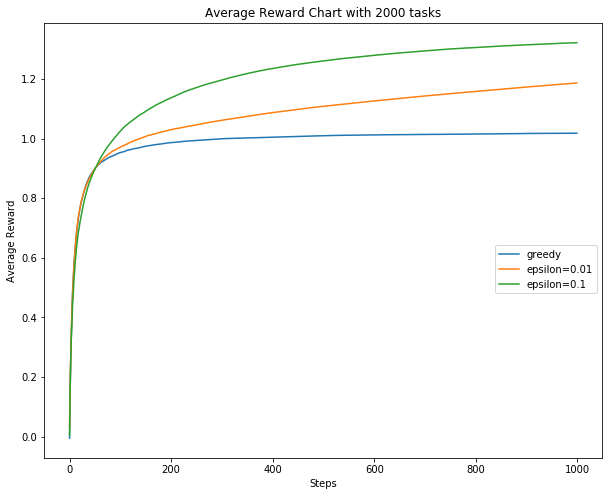

[1230.1181705   665.40432493  680.5995881  ...  293.13403116  326.8651356
  208.87762067]
[1078.39299932  944.73700036  378.40770281 ... 1286.09124698 1070.59205358
  900.24285823]
[1593.0091417  1294.58934038 1232.50426066 ... 1164.04013559 2208.04758518
 1705.83034594]
3697.4939334566548


In [24]:
# Gaussian distribution with 10-Arm Testbed
max_a = executeLearning(10, 1000, 2000, None)
print(max_a)

# Ads dataset
ads = pd.read_csv('Ads_Optimisation.csv')
max_r = executeLearning(len(ads.columns), len(ads.index), 100, ads)
#print(max_r)

